In [2]:
import json
import os
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
sns.set_theme()
API_KEY = ''
with open('KEYS.txt', 'r') as file:
    API_KEY = file.read().strip()

## Multivariate Data Analysis Problem:

Last year was the best year ever for hackers, phishers, and scammers on public blockchain networks. An estimated $3.8 Billion was stolen, primarily from Decentralized Finance protocols and by North Korea-linked attackers. Developing an identity-based positive reputation score is one key tool needed to combat and prevent these attacks, and allowing the technology to flourish and grow.

Public blockchain networks are pseudonymous, meaning that while the real-world identity of a blockchain 'user' may not be known, all of their activities and every transaction that they publish to the blockchain network is publicly available. Similar to how although the exact identity of a pseudonymous author is not known, every piece of writing they publish under the pseudonymous identity can be aggregated and analyzed. 

Blockchains are state machines, meaning the system is described by the chain of its initial, intermediary, and final states. Each state is entirely described by the previous state of the system, and the sum of all 'transactions' in each block. A transaction in this context is a valid operation within the system that mutates the blockchain data structure in some way.

A blockchain 'identity' is thus an individuals public blockchain identifier (known as a public address), and all of the transactions that affect that public address (likely as the sender or recipient). A positive reputation score associated with a blockchain identity would be a metric that accurately identifies addresses that are likely to be non-malicious.

In this analysis, I seek to identify an initial heuristic for positive reputation that can be further refined and expanded into a more comprehensive model for postive reputation. The goal is to eventlually classify, with high precision, whether a submitted transaction is "honest" or "reputation inconclusive"


## Project Description:

What we are trying to identify with this project is a set of heuristics that, with extremely high confidence, will predict that a transaction  is "honest". In this context, honest means, that the transaction is not a malicious transaction. Examples of malicious transactions include the movement of funds in the procession of fraud, money laundering, hacks, scams, etc.

To identify whether or not an ethereum transaction is honest, we must examine the transaction metadata that is publicly available (and published in real time) on the blockchain network, as well as the additional metadata related to the transaction. For our purposes, transaction metadata includes the details on the sender, the recipient, the amount, the timestamp, and over. Related transaction metadata would include additional data related to the sender, recipient, and timestamp, such as the balance of the sending address, the balance of the receiving address, and other information.

Given that transaction data is in the form of a time series, it is important to clearly define the population and objective. The population of data that we are interested in is all transaction activity from the period 2021-04-01 to 2023-04-01. We choose this upper and lower bound on the period in consideration, because the transaction volume on the ethereum network is not normally distributed across the entire lifetime of the network. We want our period to capture activity reflective of the modern network usage, and to not overweight early transaction data that may not be relevant to modern network usage. Thus, we select a period of the two current years.

## Data Source:
The data we are using is provided by Allium, which is an enterprise grade blockchain data provider. Allium provides infrastructure to enterprises that needed institutional scale access to querying live blockchain datasets. Allium's data comes directly from the nodes that it runs on the networks, so we have confidence that the data is accurate. By the nature of blockchain networks, we can have confidence that there is no missing or non-standardized data. In order to import the data from Allium, I will first have to write the SQL within their query builder, on their website, and then either export the data via CSV download, or import directly via API call into this jupyter notebook.


In [2]:
from IPython.display import HTML

url = "https://embed.theblockcrypto.com/data/on-chain-metrics/ethereum/ethereums-adjusted-on-chain-volume-daily/embed"

iframe_code = f'<iframe src="{url}" width="100%" height="420" frameborder="0" allowfullscreen></iframe>'

HTML(iframe_code)

/Users/alexcullen/anaconda3/lib/python3.9/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Data Description:
A blockchain can be understood as basically a single data structure. The Structure is entirely comprised of a linear sequence of blocks. Each block has a number, beginning at 1 (the genesis block), and updating each time a new block is found. As of the writing of this post, there have been more than 780,000 blocks discovered. Each block contains a batch of transcations. Each transaction contains details on the sender and recipient, value, etc. Ethereum blockchain addresses have one of two classifications, they are either autonomous (smart contracts), or they Externally Owned Accounts. We are only concerned with transactions initiated by Externally Owned Accounts, for the purposes of identifying "honest" transaction originators.

Additionally Allium has maintains a database table called "Ethereum Assets", which enriches the existing metadata to provide useful intelligence on things like current account balance, or time of last activity.

Together, the datasets that we are interested in are: Transactions, Blocks, Contracts, and Assets

## APA citation for datasets:
Allium.so. (n.d.). Ethereum Raw Transactions [Data set]. Allium.so. Retrieved from https://allium.so/

Allium.so. (n.d.). Ethereum Raw Blocks [Data set]. Allium.so. Retrieved from https://allium.so/

Allium.so. (n.d.). Ethereum Raw Contracts [Data set]. Allium.so. Retrieved from https://allium.so/

Allium.so. (n.d.). Ethereum Assets [Data set]. Allium.so. Retrieved from https://allium.so/

## Features available in a blockchain transaction
| Column Name       | Description	                                                                                                                                                                                         | Example                                                             |
|:--------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------|
| block_timestamp      | The time when the block that contains this transaction was included on the blockchain.                                                                                                               | 2022-09-16 04:59:59                                                 |
| block_number	                   | The length of the chain, in blocks                                                                                                                                                                   | 15543975                                                            |
| block_hash	| Unique identifier of the block that includes this transaction.	                                                                                                                                      | 0xe3eb6f24b34ab179646608ca100a3cd1d2fd1144f83544d029c0352429371b6d  |
| hash	| Unique identifier of a transaction.                                                                                                                                                                  | 	0x9068357001dc45c59a0c0383860f25fd64daeef205f723c5cbd980f280baca38 |
|from_address	| The address of the sending party of this transaction.                                                                                                                                                | 	0x7e63870ac9cb1491928e3c8922c19b2595331ac9                         |
|to_address	| The address of the receiving party of this transaction (could be a contract address). | 	0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45                         |
|value	| The amount of ether sent in this transaction, in wei.                                                                                                                                                | 	341813481343000822                                                 |
|receipt_status	| Success status of the transaction. Either 1 (success) or 0 (failure).	                                                                                                                               | 1                                                                   |
|gas	| The maximum amount of gas allocated for this transaction in wei.	                                                                                                                                    | 209392                                                              |
|gas_price	| Cost per unit of gas specified by the transaction in wei. The higher the gas price, the higher chance of getting included in a block.	                                                               | 6545492045                                                          |
|receipt_gas_used	| Gas consumed by the transaction in wei.	                                                                                                                                                             | 150272                                                              |
|max_fee_per_gas	| The maximum fee per gas that the transaction sender is willing to pay for this transaction (introduced in EIP1559)	                                                                                  | 10293849223                                                         |
|max_priority_fee_per_gas	| The maximum fee per gas the transaction sender is willing to give to validators (Proof of Stake) or miners (Proof of Work) to incentivize them to include their transaction (introduced in EIP1559)	 | 2000000000                                                          |
|transaction_index	| The position of this transaction in the block that it belongs to. The first transaction has index 0.                                                                                                 | 	62                                                                 |
|nonce	| The transaction nonce, unique to the wallet                                                                                                                                                          | 	203                                                                |

## Data Cleaning and EDA:
Our objective is to define one or more simple heuristics that can identify honest transactions with high accuracy. Total transaction count by different users is also not normally distributed. The small minority submit the vast majority of transactions. It's import for our sample to be representative of the population of unique transaction senders, and to not overweight a single individual who might send thousands or even hundreds of thousands of transactions.

To do this, we will stratify our sample and randomly select within the strata. Before we do that, we must complete some exploratory data analysis to determine what appropriate stratification for the population of data might be.

However, because this is time series data with hundreds of millions of records (if not more), we need to summarize the data such that it is possible for a query to execute in reasonable time. To begin, let's determine the total number of transactions and unique addresses transacting in the period. We will summarize this data in intervals, and observe the resulting histogram to determine the portion of transactions that fall within arbitrary buckets.

Because the dataset is too large to directly import into the jupyter notebook, the below output is the result of an SQL query run on the Allium platform.

## Population Sizing
First we will get the population of all transactions, then we will filter out all transactions originated by entities other than Externally Owned Accounts. Then we will filter again by distinct originating addresses to arrive at our population of Unique Addresses and transactions in the period.

In [3]:
data = [{"filter":"Total Transactions","count":852808230},
        {"filter":"Unique Senders", "count": 77212235},
        {"filter":"Unique Human Senders", "count": 52301378}]
df = pd.DataFrame(data)
df

,filter,count
0,Total Transactions,852808230
1,Unique Senders,77212235
2,Unique Human Senders,52301378


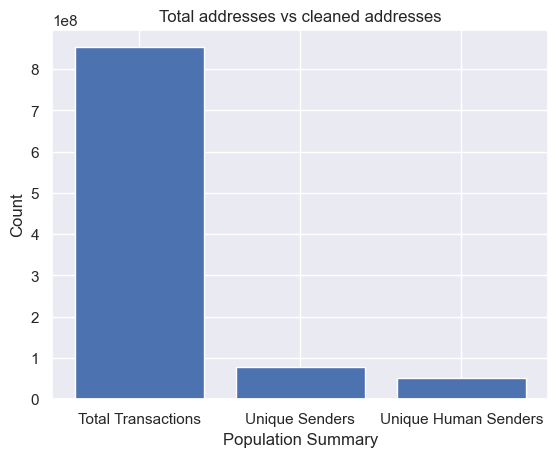

In [4]:


filter = [item["filter"] for item in data]
count = [item["count"] for item in data]

plt.bar(filter, count)
plt.xlabel("Population Summary")
plt.ylabel("Count")
plt.title("Total addresses vs cleaned addresses")
plt.show()


## Current Balance Data Visualization

In [5]:

data = [{"eth_holdings":"0-0.1 ETH","address_count":48062697},{"eth_holdings":"0.1-1 ETH","address_count":1659033},{"eth_holdings":"1-10 ETH","address_count":603474},{"eth_holdings":"10-100 ETH","address_count":151623},{"eth_holdings":">100 ETH","address_count":25693}]
df = pd.DataFrame(data)

In [6]:
df

,eth_holdings,address_count
0,0-0.1 ETH,48062697
1,0.1-1 ETH,1659033
2,1-10 ETH,603474
3,10-100 ETH,151623
4,>100 ETH,25693


In [7]:
df.columns

Index(['eth_holdings', 'address_count'], dtype='object')

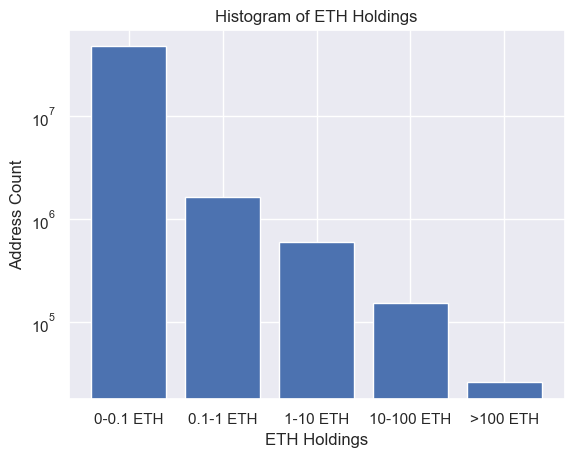

In [8]:
import matplotlib.pyplot as plt

eth_holdings = [item["eth_holdings"] for item in data]
address_count = [item["address_count"] for item in data]

plt.bar(eth_holdings, address_count)
plt.xlabel("ETH Holdings")
plt.ylabel("Address Count")
plt.yscale("log")
plt.title("Histogram of ETH Holdings")
plt.show()

The above histogram shows the distribution of current ethereum balances (in log scale) for all wallets that transacted in the period .

## Total transaction count data visualization


In [9]:
data=[{"txn_count":"0. 0","address_count":74701}
      ,{"txn_count":"b. 1-10 txns","address_count":211109}
      ,{"txn_count":"c. 11-100 txns","address_count":191531}
      ,{"txn_count":"d. 101-1000 txns","address_count":114627}
      ,{"txn_count":"e. >1000 txns","address_count":21348}
      ,{"txn_count":"sum","address_count":613316}]
df = pd.DataFrame(data)
df

,txn_count,address_count
0,0. 0,74701
1,b. 1-10 txns,211109
2,c. 11-100 txns,191531
3,d. 101-1000 txns,114627
4,e. >1000 txns,21348
5,sum,613316


Text(0.5, 1.0, 'Histogram of Transaction Counts')

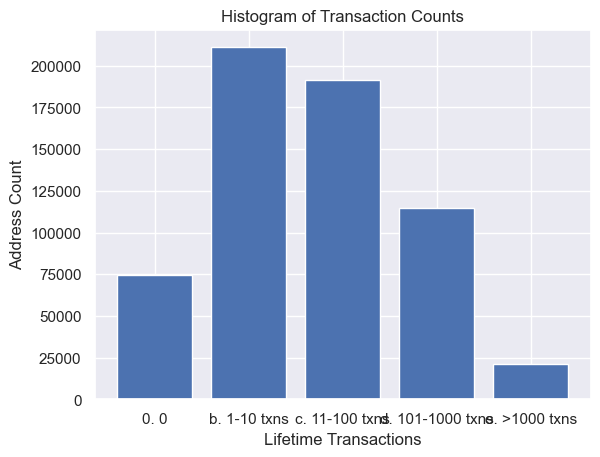

In [10]:
import matplotlib.pyplot as plt

tx_counts = [item["txn_count"] for item in data[:-1]]
address_count = [item["address_count"] for item in data[:-1]]

plt.bar(tx_counts, address_count)
plt.xlabel("Lifetime Transactions")
plt.ylabel("Address Count")
plt.title("Histogram of Transaction Counts")

A histogram of the lifetime transaction count of all transacting addresses in the period

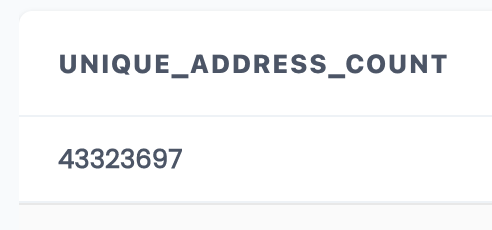

In [11]:
from IPython.display import Image

# Replace 'image_file_path' with the relative path of your image file
image_file_path = 'path/to/your/image.png'

# Display the image in the notebook
Image(filename='img/Unique_Address_Count.png')

## Sampling:

Given the sheer volume of transactions and data in the period, I will not be able to perform any analysis using the full population data, and will instead need to perform sample selection to select a subset of unique addresses that transacted over the last two years.

The goal will be to stratify our sample and use our stratified sample to perform further testing.

## Sample Size Selection:
First, we must determine an appropriate sample size. To do this, we will use a formula for estimating the appropriate sample size that we learned in class: Z^2 * p ( 1 - p)/ MoE^2. Z is the Z-score the level of accuracy that we want to have when using the sample to estimate parameters. We choose a Z-score that represents 2 standard deviations from the mean, suggesting that we are 95% confident that the population parameter is within two standard deviations of our estimate. We choose a p value of .5 as that is the most conservative estimate we can make, saying that we know essentially nothing about the distribution of the actual population parameter. We choose a margin of error at .01, so that we can be as precise as is reasonable with our estimates. The size of the population is well over 400 million records, so we have a lot of data to pull from, and therefor the privilege of selecting a larger sample size for our estimates.

A comment on error. Our concern would be that we determine a transaction to be a good transaction when, in fact, it was a malicious transaction.

1.96^2 * (.5*(1-.5))/(.01^2) = 9604

#### Sample Selection
Within the Allium platform, we queried the population of all unique sending addresses within the last two years, filtered out those that were not human, and then assigned each row a random row number, and then selected the first 9604 rows. This is the process by which we identified the unique addresses in our random sample. We then exported this data into a csv file included in the library.

Next, we queried the table of transactions, filtering on those that have a from_addres or to_address that is in our subset of addresses selected for our sample. The purpose of this step is to perfom exploratory data analysis and better understand the transaction nature of sample addresses so that we can then perform stratification on the sample.

The following three code blocks assisted in the data export of those addresses

In [3]:
sample_addresses = pd.read_csv('./sample_addresses.csv')
def get_batches(df, batch_size = 10):


    # Get the total number of batches
    total_batches = (len(df) + batch_size - 1) // batch_size
    batches = []
    # Loop through each batch
    for batch_number in range(total_batches):
        # Get the start and end indices for slicing
        start_index = batch_number * batch_size
        end_index = start_index + batch_size

        # Get the current batch of IDs
        batch_ids = df[start_index:end_index]
        batch_id_str = ','.join(f"'{id}'" for id in batch_ids)
        batches.append(batch_id_str)
    return batches
batch_size = 1000
batches = get_batches(sample_addresses.from_address, 10)[0]

In [58]:

inset = set(transaction_data['from_address']).union(set(transaction_data['to_address']))
len(inset)
retryAddresses = list(set(sample_addresses.from_address).difference(inset))
# Define the batch size
batch_size = 1

# Get the total number of batches
total_batches = (len(retryAddresses) + batch_size - 1) // batch_size
retryBatches = []
# Loop through each batch
for batch_number in range(total_batches):
    # Get the start and end indices for slicing
    start_index = batch_number * batch_size
    end_index = start_index + batch_size

    # Get the current batch of IDs
    batch_ids = retryAddresses[start_index:end_index]
    batch_id_str = ','.join(f"'{id}'" for id in batch_ids)
    retryBatches.append(batch_id_str)
retryBatches
# Get the total number of batches

["'0x473300df21d047806a082244b417f96b32f13a33'"]

In [20]:

QUERY_ID = "ieuP4ZH63m1hKjOZyvuW"
urlhead = "https://api.allium.so/api/v1/explorer/queries/"

# Get the total number of batches
#total_batches = (len(df.from_address) + batch_size - 1) // batch_size
# Loop through each batch

def run_query(urlhead, QUERY_ID, params={}, run_ids=[], failed_runs=[]):
    response = requests.post(
        urlhead + QUERY_ID + "/run-async",
        json={"parameters":
                  params,
              "run_config": {"limit": 250000}},
        headers={"X-API-Key": API_KEY},
        timeout=10,
    )
    try:
        print(response.status_code, response.text)
        run_id = response.json()["run_id"]
        print(f"Query run created with ID: {run_id}")
        run_ids.append(run_id)
    except json.JSONDecodeError as e:
        print(e)
        failed_runs.append(run_id)

def get_results(urlhead, run_id, df , results, successful_retrieves=[],  failed_retrieves=[], no_results=[]):
    polling_interval, start, timeout = 1, time.time(), 20 * 60  # 20min timeout
    while time.time() < start + timeout:
        run_status = ''
        response = requests.get(urlhead + run_id + "/status",
            headers={"X-API-Key": API_KEY},
            timeout=10,
        )
        try:
            run_status = response.json()
        except json.JSONDecodeError as e:
            failed_runs.append(run_id)
            break
        if run_status not in ["created", "queued", "running"]:
            break
        print(f"Current status: {run_status}. Waiting {polling_interval}s...")
        time.sleep(polling_interval)

    if run_status == "success":
        successful_retrieves.append(run_id)
        response = requests.get(urlhead + run_id + "/results?f=json",
            headers={"X-API-Key": API_KEY},
        )
        res = response.json()
        # Convert the API response data to a DataFrame
        new_data = pd.DataFrame(res['data'])

        # Concatenate the empty DataFrame with the new data, creating new columns as needed
        df = pd.concat([df , new_data], axis=0, ignore_index=True)
        results.append(res)
        print(
            f"Query returned {len(results['data'])} rows, with "
            f"fields: {', '.join(column.get('name') for column in results['meta']['columns'])}"
        )

    elif run_status == "failed":
        failed_retrieves.append(run_id)
        response = requests.get(urlhead + run_id + "/error",
            headers={"X-API-Key": API_KEY},
        )
        error_message = response.json()
        print(
            f"Query failed with error: {error_message}"
        )
    else:
        no_results.append(run_id)
        print(f"Query run finished with status: {run_status}. No results.")
    print(df.shape)
df = pd.DataFrame()
results = []
successful_retrieves = {}
failed_retrieves = []
no_results = []
for run_id in run_ids:
    get_results(urlhead, run_id, df, results, successful_retrieves, failed_retrieves, no_results)

KeyboardInterrupt: 

In [ ]:
QUERY_ID = "ieuP4ZH63m1hKjOZyvuW"
urlhead = "https://api.allium.so/api/v1/explorer/queries/"
run_ids = []
failed_runs = []
for batch in batches:
    run_ids = run_query(urlhead, QUERY_ID, {"sampleAddresses": batch}, run_ids=run_ids, failed_runs=failed_runs)
df = pd.DataFrame()
results = []
successful_retrieves = {}
failed_retrieves = []
no_results = []
for run_id in run_ids:
    get_results(urlhead, df, run_id, results, successful_retrieves, failed_retrieves, no_results)



#### Loading the Dataframe
In total, we pulled some 130,000 transactions from the table of all transactions, where either the from or to address was an address in our sample. To retain the data, we exported the transactions as csvs in a subdirectory, and load them each csv file into the transaction_data dataframe below.

In [13]:
# Specify the directory path
dir_path = './transactionData'

# List all files in the directory
file_names = os.listdir(dir_path)

# Loop through the files
for file_name in file_names:
    # Create the full file path by joining the directory path and the file name
    file_path = os.path.join(dir_path, file_name)
    if file_name.startswith('.'):
        continue
    # Check if it's a file (and not a directory)
    if os.path.isfile(file_path):
        # Open and read the file
        with open(file_path, 'r') as file:
            print(f'reading file {file_path}')
            try:
                file_content = file.read()
            except Exception as e:
                print(file_path, e)
            json_data = json.loads(file_content)
            print(f"number of rows = {len(json_data['data'])}")
            new_data = pd.DataFrame(json_data['data'])
            transaction_data = pd.concat([transaction_data, new_data], axis=0, ignore_index=True)
            # Pr
transaction_data.head()

reading file ./transactionData/Get Transaction Data - XJwunSI9ASKapRKveZA2.json
number of rows = 20575


NameError: name 'transaction_data' is not defined

## We can see below the shape of our dataframe is 156,536 transactions with 22 unique rows, matching the number of rows in our original description of the ethereum transaction data

In [3]:
df = pd.read_csv('transactions.csv')
td = df.copy()
td.drop('Unnamed: 0', axis=1, inplace=True)
td.shape

(156536, 21)

## Looking at the first five rows of transaction data values to get a sense of the data

In [4]:
td.head()

,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,...,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
0,0x04c7ad20d35b76145dbd5ba701f55fb793007bc9bad6...,109990,74,0x8f22f2063d253846b53609231ed80fa571bc0c8f,0x6321495b415c873d4f04b84ece0519754788edad,1494111550000000000,207128,135000000000,0x,3674628,...,NaN,NaN,1.0,2021-03-20T09:42:21,12074960,0x48a2fc67cdc435b09117297d049eba5e04909be8872a...,NaN,NaN,NaN,1.350000e+11
1,0x0a418e5f6b2246f7f1ba4ad74b8f50863ac24ca9eaac...,0,9,0xadee4b0890053fc15aed0990d867f5062184ebf7,0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be,1434171200000000000,42000,64000000000,0x,706756,...,NaN,NaN,1.0,2021-05-02T18:10:52,12356270,0x92e261d44236134c821492df1cca4d04fe61ba76cbc6...,NaN,NaN,NaN,6.400000e+10
2,0x86a8f415bbf3eb6f8621daea85b96918efabb9a4cd65...,177,150,0x040c18296688ce56aaed9fbf5e765c7d452f8434,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0,212765,23000000000,0x38ed1739000000000000000000000000000000000000...,13697132,...,NaN,NaN,1.0,2021-05-02T10:36:21,12354235,0x202226ebc999ab15d52b3627d0b55989904c8414850f...,NaN,NaN,NaN,2.300000e+10
3,0xbdd7c7c1b8bc7b6c7ed4ec56074ebae3e10e513e1203...,157,57,0x040c18296688ce56aaed9fbf5e765c7d452f8434,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0,204264,101000001459,0x38ed1739000000000000000000000000000000000000...,5340632,...,NaN,NaN,1.0,2021-03-21T08:53:20,12081144,0xff7d5076b0e7b611ea5bf04704fb0d209313c5380959...,NaN,NaN,NaN,1.010000e+11
4,0x1908da7917c43e7523501042054922d2472708283a6e...,154,48,0x040c18296688ce56aaed9fbf5e765c7d452f8434,0xb1f871ae9462f1b2c6826e88a7827e76f86751d4,0,48726,101000000000,0x095ea7b30000000000000000000000007a250d5630b4...,2371573,...,NaN,NaN,1.0,2021-03-21T08:24:53,12081028,0xee9ee72d6fbfc2fbe36afd4c935870a699e2137482ef...,NaN,NaN,NaN,1.010000e+11


## Looking at the data types of the dataframe, we can see that 'value' which should be an integer is an object.

In [5]:
td.dtypes

hash                            object
nonce                            int64
transaction_index                int64
from_address                    object
to_address                      object
value                           object
gas                              int64
gas_price                        int64
input                           object
receipt_cumulative_gas_used      int64
receipt_gas_used                 int64
receipt_contract_address        object
receipt_root                    object
receipt_status                 float64
block_timestamp                 object
block_number                     int64
block_hash                      object
max_fee_per_gas                float64
max_priority_fee_per_gas       float64
transaction_type               float64
receipt_effective_gas_price    float64
dtype: object

## We cast the value column to type float, it was originally type 'object' and it's values are too large to be cast as integers. We then split the 'input' column into a binary 'has_input' or 'no_input'. Input represents the instructions within the transaction that are provided to a smart contract, if the transaction is interacting with a smart contract. This is not a required field, and thus many transactions will have a null or '0x' value as indicator that no input was passed. This is a useful way of determining whether or not the transaction is interacting with a smart contract or not.

In [12]:
td['value'] = td['value'].astype(float)
td['has_input'] = td['input'].apply(lambda x: 0 if x == '0x' else 1)
td['contract_creation'] = td['to_address'].isnull().astype(int)
td_clean = td.drop(['input', 'hash', 'block_hash','transaction_type'], axis=1)

## Next we look to see if there any row with null values, and there are. The null values for all of these are optional. A null value for the 'to_address' means that the transaction is being used to create a smart contract on the ethereum blockchain.

In [14]:
td.loc[:,td.isnull().any() == True].columns

Index(['to_address', 'receipt_contract_address', 'receipt_root',
       'receipt_status', 'max_fee_per_gas', 'max_priority_fee_per_gas',
       'transaction_type', 'receipt_effective_gas_price'],
      dtype='object')

## Next we need to convert the 'value' to native currency of eth. Currently all values are in wei which = 10e-18 ethereum

In [15]:
def wei_to_eth(wei):
    return wei / 10**18
td[['value','gas','gas_price','receipt_gas_used']] = td[['value','gas','gas_price','receipt_gas_used']].apply(wei_to_eth)

## Next we are going to filter the sample transaction data by those where the from_address is in our sample set, and then we will group the transaction by the from_address. Each eth transaciton has a nonce, a nonce is a value that monotonically increases each time the sender sends a new transaction. It can be used as a proxy for total transaction count. We will need to increase the nonce value of each row by 1, because nonces start at 0.

,from_address,rn,total_count,address,bytecode,block_timestamp,block_number,block_hash,transaction_hash,deployer
0,0x0d5a4d9ef11d4b69bb1b3eb5bb72312f41e6a7e5,4370,77212235,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0x631e52873b49d4ff38d7585f89177152a836294b,2487,77212235,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0x5e11131bfe64dcf7d9a499a944886b01ab556853,3304,77212235,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0xa4ec3b0e86bf9b831e433c67cd558adfcdf41cf5,3439,77212235,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0xa45b5c7ff401f037796c4dcf2b82b92178c7605f,939,77212235,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9599,0x7592b5a3dc865d0be27f4e6bef7a28625f2de8bd,4366,77212235,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9600,0x6253f3eefb16a75a2f894f286132e52832066e50,5212,77212235,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9601,0x3142594707755f7eac80bb86a1895daadddde46b,7971,77212235,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9602,0x0ada659aa31b6f5c6c76583b5cf2733a5885f9fa,9270,77212235,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [185]:
filtered_df_from = td[td['from_address'].isin(sample_addresses.from_address)].groupby('from_address')
total_transaction_count = filtered_df_from.max('nonce') + 1
total_transaction_count

,Unnamed: 0,nonce,transaction_index,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,receipt_status,block_number,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
from_address,,,,,,,,,,,,,,
0x0005de09b0553fc3ef0c6eccc617180b01d25982,55390,2,203,1.325382,1.0,1.0,14779319,1.0,2.0,15253433,NaN,NaN,1.0,1.600000e+10
0x00083251222d77d1fb3607a75340df2815b94639,155781,3,146,1.091947,1.0,1.0,6428933,1.0,2.0,15789651,NaN,NaN,1.0,1.413070e+11
0x000899626a88f03edd5acfea95157095b1fa93e4,29177,12,296,1.261980,1.0,1.0,22112222,1.0,2.0,16065550,NaN,NaN,1.0,1.245357e+11
0x000ab3cbc6595f74e89d2b16faafef20ab1db7a0,20555,4,95,1.100000,1.0,1.0,3934030,1.0,2.0,12701368,NaN,NaN,NaN,1.070000e+11
0x0011c319d96a3f8bfde5a2c906bf327cff9ddf2a,14983,2,108,1.059391,1.0,1.0,4854882,1.0,2.0,13223407,NaN,NaN,NaN,9.900000e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xffd947739c9109a22b57a500bfeb128f1f80bd96,102377,2,249,1.009596,1.0,1.0,9127119,1.0,2.0,12450420,NaN,NaN,NaN,1.210000e+11
0xffe6e023f8985db15624365c22449db70a2b7ab8,66930,13,76,4.428846,1.0,1.0,5517030,1.0,2.0,14389029,NaN,NaN,NaN,3.330000e+11
0xffef9a53cc67168522cc4f68b9756f719f56aa0a,137179,20,297,1.340000,1.0,1.0,22435453,1.0,2.0,17053446,4.563185e+10,2.795213e+10,NaN,3.403730e+10


## The following chart helps us better understand the distribution of total transactions, and the number of addresses at each nonce value. We can see that the vast majority of addresses have less than 10 lifetime transactions, while a handful have many more. This resembles an exponential distribution, as the scale is in log

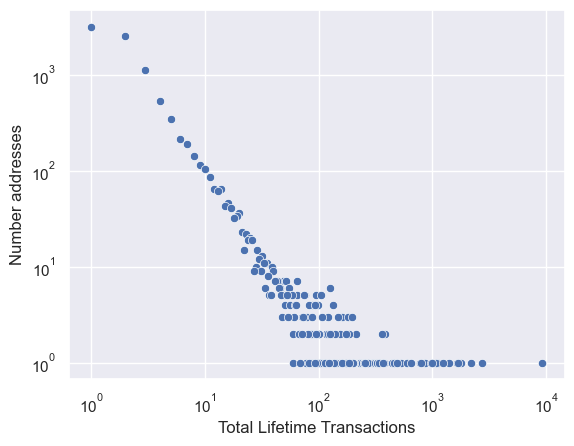

In [338]:
value_counts = total_transaction_count['nonce'].value_counts().reset_index()
value_counts.columns = ['nonce', 'count']
value_counts['count']
sns.scatterplot(data=value_counts, x='nonce', y='count')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Total Lifetime Transactions')
plt.ylabel('Number addresses')
plt.show()

## We perform the same analysis as above, except on received transactions to our unique subset of sample addresses. We see that the distribution is very nearly the same

In [183]:
filtered_df_to = td[td['to_address'].isin(sample_addresses.from_address)].groupby('to_address')

to_address
0x0005de09b0553fc3ef0c6eccc617180b01d25982     5
0x00083251222d77d1fb3607a75340df2815b94639     2
0x000899626a88f03edd5acfea95157095b1fa93e4     5
0x000ab3cbc6595f74e89d2b16faafef20ab1db7a0     1
0x0011c319d96a3f8bfde5a2c906bf327cff9ddf2a     1
                                              ..
0xffd947739c9109a22b57a500bfeb128f1f80bd96     1
0xffe6e023f8985db15624365c22449db70a2b7ab8    12
0xffef9a53cc67168522cc4f68b9756f719f56aa0a    12
0xfff7404507e07d7b95ff622c1908784e88b01b17     1
0xfff8320230b55a31aeff760d1ddb2c6d0fbb93c0     1
Name: hash, Length: 9140, dtype: int64

Population Stratification:
We are interested in determining the stratification of population

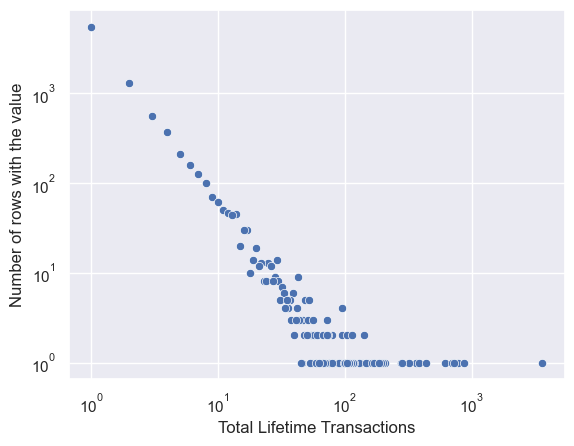

In [131]:
value_counts = filtered_df_to['hash'].count().value_counts().reset_index()
value_counts.columns = ['hash', 'count']
sns.scatterplot(data=value_counts, x='hash', y='count')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Lifetime Transactions')
plt.ylabel('Number of rows with the value')
plt.show()

## Using the dataframes describe feature, we can see that the mean transaciton value for each  is 2.2, however there is extremely variance amongst the values. We will see that when we plot this, a few outliers skew the data significantly

In [206]:
total_transaction_count['value'].describe()

count    9603.000000
mean        2.262232
std        31.168757
min         0.000000
25%         0.005047
50%         0.048077
75%         0.315841
max      2000.000000
Name: value, dtype: float64

In [213]:
threshold = 1e-3  # Adjust the threshold value as needed
clipped_df = total_transaction_count.copy()
clipped_df['value'] = clipped_df['value'].clip(lower=threshold)
clipped_df.describe()

,value,nonce
count,9603.000000,9603.000000
mean,2.262387,11.611371
std,31.168745,114.655924
min,0.001000,1.000000
25%,0.005047,1.000000
50%,0.048077,2.000000
75%,0.315841,4.000000
max,2000.000000,9178.000000


## We will clip some of the values here, seeing as the float values are so near zero that pandas can't appropriately compute them.

In [215]:
clipped_df['value']

from_address
0x0005de09b0553fc3ef0c6eccc617180b01d25982    0.325382
0x00083251222d77d1fb3607a75340df2815b94639    0.091947
0x000899626a88f03edd5acfea95157095b1fa93e4    0.261980
0x000ab3cbc6595f74e89d2b16faafef20ab1db7a0    0.100000
0x0011c319d96a3f8bfde5a2c906bf327cff9ddf2a    0.059391
                                                ...   
0xffd947739c9109a22b57a500bfeb128f1f80bd96    0.009596
0xffe6e023f8985db15624365c22449db70a2b7ab8    3.428846
0xffef9a53cc67168522cc4f68b9756f719f56aa0a    0.340000
0xfff7404507e07d7b95ff622c1908784e88b01b17    0.019814
0xfff8320230b55a31aeff760d1ddb2c6d0fbb93c0    0.002460
Name: value, Length: 9603, dtype: float64

## Histogram of transaction values, we can wee that vast majority of all transactions have little to no eth moving between them. This makes sense, as a transaction to a smart contract would have no eth valuing moving between addresses directly.

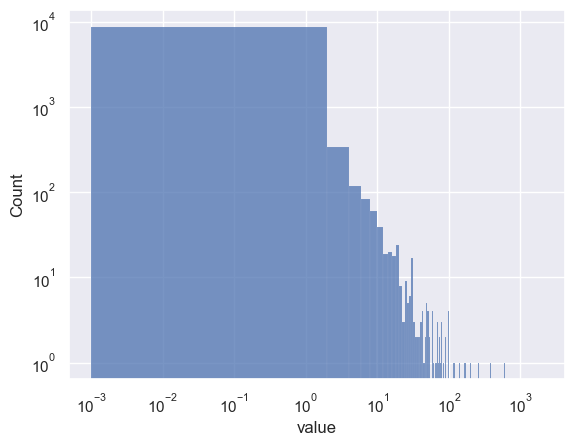

In [230]:
sns.histplot(clipped_df['value'],bins=1000)
plt.xscale('log')
plt.yscale('log')

In [340]:
## When we try to plot this on a boxplot, we see that all the values are very nearly zero

<AxesSubplot: >

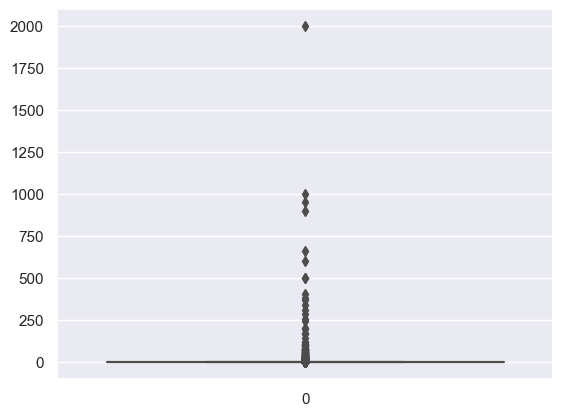

In [339]:
sns.boxplot(clipped_df['value'])

## Perfoming the same analysis except on received values instead of sent values. We can see that the distribution is equally skewed

In [245]:
threshold = .1  # Adjust the threshold value as needed
upper_threshold = 1001
filtered_df = clipped_df[(clipped_df['value'] >= threshold) & (clipped_df['value'] <= upper_threshold)]
filtered_df.describe()

,value,nonce
count,3812.000000,3812.000000
mean,5.141642,23.889297
std,37.209904,179.399969
min,0.100000,1.000000
25%,0.200763,1.000000
50%,0.500000,3.000000
75%,1.679648,10.000000
max,999.000000,9178.000000


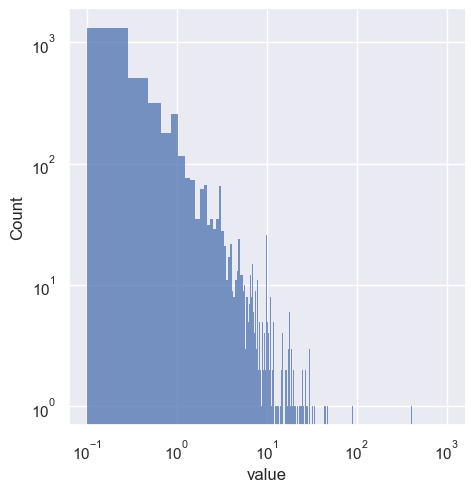

In [255]:
sns.displot(filtered_df['value'])
plt.xscale('log')
plt.yscale('log')

## Next we plot the relationship between transactions sent and received which allows us to see whether there is a correlation between sent and received transaction volumes. Do addresses that receive transactions send more transactions? The answer seemst to be yes!

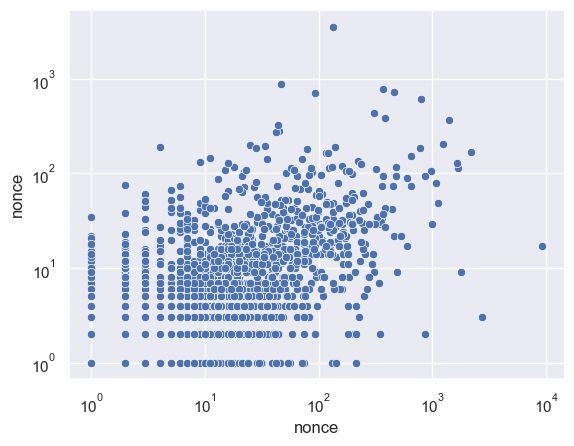

In [299]:
threshold = 1e-3
sent_volume= filtered_df_from.nonce.count()
received_volume= filtered_df_to.nonce.count()

sns.scatterplot(x=sent_volume, y=received_volume)
plt.xscale('log')
plt.yscale('log')



## Finally we plot a correlation heatmap of the nonce, transaction_index, value, gas, gas_price, has_input, and nonce. We can see that when a transaction has an input, that the gas_price is higher. This makes sense as that transaction is interacitng witha  smart contract and using gas. There seems to be little correlation otherwise

In [324]:
correlation_matrix = td[td['from_address'].isin(sample_addresses.from_address)][['nonce','transaction_index','value','gas','gas_price','has_input','nonce']].corr()

<AxesSubplot: >

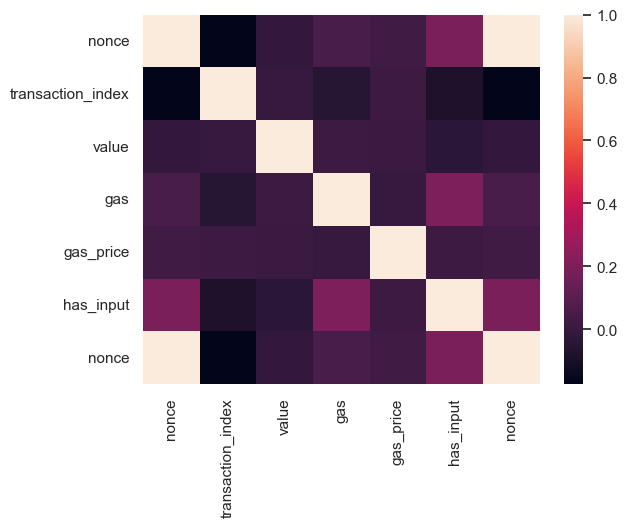

In [325]:
sns.heatmap(correlation_matrix)

## We perform the same analysis as above on the received transacitonsx, and note that there is littele correlation

<AxesSubplot: >

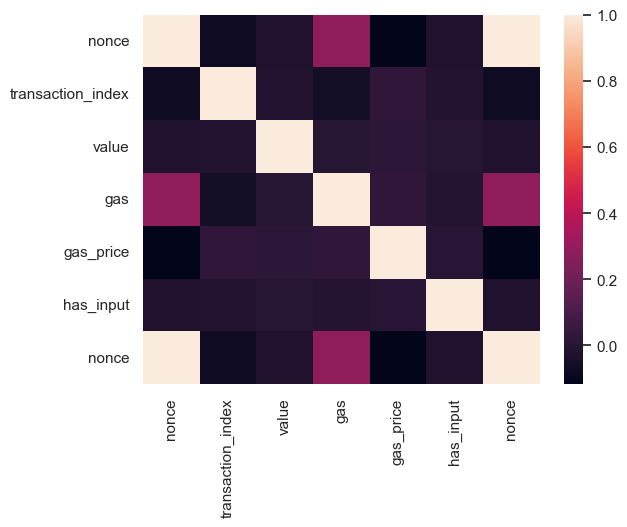

In [326]:
correlation_matrix = td[td['to_address'].isin(sample_addresses.from_address)][['nonce','transaction_index','value','gas','gas_price','has_input','nonce']].corr()
sns.heatmap(correlation_matrix)

In [304]:
received_volume.shape

(9140,)

In [270]:
received_volume['0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a']
sent_volume['0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a']

1630.4989611911897

In [295]:
td.loc[(td['from_address'] == '0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a')]

,Unnamed: 0,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,...,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
40,40,0xd9205c1358c81b612112e83a848659dbbaf3c3940eb9...,771,152,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0x000000000000ad05ccc4f10045630fb830b95127,0.0,3.482790e-13,4.346400e-08,0x9a1fc3a7000000000000000000000000000000000000...,...,NaN,NaN,1.0,2023-04-19T01:12:35,17077326,0x0b602c5c491d5e95d30dcc4f598d1d49fd5e3906cc72...,6.028325e+10,1.000000e+08,NaN,4.346400e+10
52,52,0x0b5ab2a1dc1011389ab10b0a0ce75c1b39e13314e736...,760,19,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0.0,2.883250e-13,3.599291e-08,0x77725df60000000000000000000000005026f006b857...,...,NaN,NaN,0.0,2023-04-18T05:53:59,17071630,0x719e0a6b96e45a9f0bc0ad0250f5e12a162cad1ca403...,8.500000e+10,5.000000e+09,NaN,3.599291e+10
53,53,0x5013c40937d53ae6517c7a223f41d1e6cfd49c3460ec...,752,107,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0x000000000000ad05ccc4f10045630fb830b95127,0.0,9.616900e-14,4.358868e-08,0xab7e8cba000000000000000000000000000000000000...,...,NaN,NaN,1.0,2023-04-18T02:21:11,17070591,0x6e78fcd47de69f09b11749edc9359328108458dbcdc1...,5.684118e+10,1.000000e+08,NaN,4.358868e+10
54,54,0x1963af08ed339d6f975dc5a17cda2929e86e1af56cc0...,756,134,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0x00000000000001ad428e4906ae43d8f9852d0dd6,0.0,7.399700e-14,3.008238e-08,0xfd9f1e10000000000000000000000000000000000000...,...,NaN,NaN,1.0,2023-04-18T04:50:11,17071320,0xf52a40a48e589c14a4bc8700d05c58f5739f2e638d4f...,4.188407e+10,1.000000e+08,NaN,3.008238e+10
97,97,0x92429bcb2d117f23aebd395a0b3a29fd6e23e37ec17b...,741,132,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0x00000000006c3852cbef3e08e8df289169ede581,13.0,1.685800e-13,3.104246e-08,0xb3a34c4c000000000000000000000000000000000000...,...,NaN,NaN,1.0,2023-04-16T20:08:23,17061704,0x34d8c605ebb7b914816f31824b257d126c79f85a2986...,4.841584e+10,1.000000e+08,NaN,3.104246e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20348,20348,0x9b3c10badad06c013f3d3d944ea3330d74de58bb9443...,110,54,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0x000000000000ad05ccc4f10045630fb830b95127,0.0,6.168900e-14,1.632164e-08,0xf4acd740000000000000000000000000000000000000...,...,NaN,NaN,1.0,2023-01-16T03:29:23,16416673,0xa83f86cab9c90dd0fde7d0eda583f28e3d5bc5434a77...,2.106134e+10,1.500000e+09,2.0,1.632164e+10
20355,20355,0xf7fc8f2d4321a6d34b7955c92868d4b75c0d88f4350a...,109,113,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0xff730864741339aeea6110d2a865749c9f68f7fa,0.0,6.374700e-14,1.782995e-08,0xa22cb4650000000000000000000000001e0049783f00...,...,NaN,NaN,1.0,2023-01-16T03:11:11,16416582,0xa5d945f94af5b56bb7814a6a8533e1c9474c2bf1d217...,2.277403e+10,1.500000e+09,2.0,1.782995e+10
20378,20378,0x7af6745f31c985a5668dbd21f6ff253e6e53d70661d7...,127,137,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0xed5af388653567af2f388e6224dc7c4b3241c544,0.0,4.618900e-14,2.594750e-08,0xa22cb465000000000000000000000000f849de01b080...,...,NaN,NaN,1.0,2023-01-18T15:23:11,16434561,0x78a024e8103c2de9ba0632bf2ccce2eeb62edd369aea...,3.393619e+10,1.500000e+09,2.0,2.594750e+10
20391,20391,0xcf6d33a98ce5ddde63aa0432638115ea26b4eec1d242...,150,51,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0x7eba6418388cac0b81c26f9b76d7ea6877bf8308,0.0,4.618400e-14,1.717819e-08,0xa22cb465000000000000000000000000000000000001...,...,NaN,NaN,1.0,2023-01-20T07:55:59,16446658,0x02c4aa4379c37092f4d85d68007217c374f8210faebf...,2.105704e+10,1.500000e+09,2.0,1.717819e+10


In [292]:
td.loc[td['to_address'] == '0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a']


,Unnamed: 0,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,...,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
37,37,0x78711fc8064af24cb8316c33d0d2ed7b9970561fd2d7...,779704,33,0xf89d7b9c864f589bbf53a82105107622b35eaa40,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,7.665357,9.000000e-14,4.109056e-08,0x,...,NaN,NaN,1.0,2023-04-19T03:20:23,17077954,0xa11ef6a68959ce0a2c478658971d5e67f29b45b5fe69...,4.000000e+11,2.000000e+09,NaN,4.109056e+10
1164,1164,0xe788d18e6565574541f274ec64977f3618ed58277576...,1076,74,0xc033c5a44cb1f2d95dfb56d731fcf64b9fdaa1b2,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0.008950,2.100000e-14,1.626357e-08,0x,...,NaN,NaN,1.0,2023-01-15T06:10:35,16410326,0xddb335787f69ac3f4d49a6cd0a7d0f4d6f5c5c8980a9...,2.060233e+10,1.500000e+09,2.0,1.626357e+10
1165,1165,0xfe69cc76e9d12afd5d4cc4e81dd8632ba36839eba7eb...,37,58,0x2cf72e36b0399481d4c4f863e4b62b6043396309,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0.265027,2.100000e-14,1.536685e-08,0x,...,NaN,NaN,1.0,2023-01-15T06:11:59,16410333,0xcb215c4eb48c11c83d5bac2e2701da8bffeb4afd5312...,2.052932e+10,1.500000e+09,2.0,1.536685e+10
1257,1257,0xf80431ebc6192a6a2d5920733d86254c86368dd0d4dc...,11,148,0x53b9b67e7e41f6dd5ae8d8ed03e4f27022d207bc,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0.048908,2.100000e-14,5.200000e-08,0x,...,NaN,NaN,1.0,2023-02-17T17:58:35,16650056,0xaa7e9dafc1a66aeed086c484f093df1ef98234f19bc3...,NaN,NaN,NaN,5.200000e+10
1258,1258,0xcfe6116a9c7eca20db9857b96c53ac5beacc29da71e0...,12,132,0xbe78baaa871eea23c62d7c0eafbaceaed193f6b1,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0.048908,2.100000e-14,5.200000e-08,0x,...,NaN,NaN,1.0,2023-02-17T17:58:35,16650056,0xaa7e9dafc1a66aeed086c484f093df1ef98234f19bc3...,NaN,NaN,NaN,5.200000e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19521,19521,0x55a2a477088b40763f1b650e0c11b8fd22362d132548...,281045,121,0xcbd6832ebc203e49e2b771897067fce3c58575ac,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0.500000,9.000000e-14,2.206921e-08,0x,...,NaN,NaN,1.0,2023-02-28T00:59:23,16723253,0x8fae4d8c518c3f2c899b15f2b5d220ad9d059a8f959d...,4.237303e+10,6.218962e+07,NaN,2.206921e+10
19741,19741,0xa9d27767d74f06b457f2a3f55602ce233dde9fcc68a4...,251378,109,0xcbd6832ebc203e49e2b771897067fce3c58575ac,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0.357102,9.000000e-14,2.147053e-08,0x,...,NaN,NaN,1.0,2023-02-02T04:36:35,16538778,0x002281adda90eefcf52b982e67c7de07acac6b4af939...,4.152120e+10,1.596770e+08,NaN,2.147053e+10
19745,19745,0x82c51d4a588f7f2264683741676355fa991356b86d41...,250346,563,0xcbd6832ebc203e49e2b771897067fce3c58575ac,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0.271777,9.000000e-14,2.994342e-08,0x,...,NaN,NaN,1.0,2023-02-01T05:51:11,16531993,0x69e18cda51683deb537f9f10313d8d21173623449e1d...,4.200620e+10,1.859763e+08,NaN,2.994342e+10
19804,19804,0xdfd268a9203b6bba8b3692c1075c48ec85f65ff81098...,245041,132,0xcbd6832ebc203e49e2b771897067fce3c58575ac,0x0f65465ae79bab6241ec51e2d20d3183d76c6b0a,0.082434,9.000000e-14,1.517176e-08,0x,...,NaN,NaN,1.0,2023-01-27T05:09:11,16495972,0x819542b8e9edd29ccc748f8966d628d828443bbf8f8d...,2.679578e+10,2.327841e+08,NaN,1.517176e+10


In [11]:
batches = get_batches(sample_addresses.from_address,1000 )
run_ids = []
failed_runs = []
for batch in batches:
    run_query(urlhead,'Q3mIWYDo3WvP668UleVP', {"sample_addresses": batch},run_ids, failed_runs)



200 {"run_id":"G7PAgWEYATu8CvRYlni4"}
Query run created with ID: G7PAgWEYATu8CvRYlni4
200 {"run_id":"TZVa2JjYfilIjApnHhlQ"}
Query run created with ID: TZVa2JjYfilIjApnHhlQ
200 {"run_id":"qJPn8Tm12SK5SPnnPdRr"}
Query run created with ID: qJPn8Tm12SK5SPnnPdRr
200 {"run_id":"9JaMAYWHvE9VC9XQHrLJ"}
Query run created with ID: 9JaMAYWHvE9VC9XQHrLJ
200 {"run_id":"a23m1fYrV2AmYvPm6XHk"}
Query run created with ID: a23m1fYrV2AmYvPm6XHk
200 {"run_id":"0ScAezmWBpDLYr1N3fFh"}
Query run created with ID: 0ScAezmWBpDLYr1N3fFh
200 {"run_id":"fNpnGXlrHVuyz69jb4aD"}
Query run created with ID: fNpnGXlrHVuyz69jb4aD
200 {"run_id":"QqsUKlHWcDzffGLK8COS"}
Query run created with ID: QqsUKlHWcDzffGLK8COS
200 {"run_id":"bEYldJ7owbeN2sbqvQZr"}
Query run created with ID: bEYldJ7owbeN2sbqvQZr
200 {"run_id":"AMlsdw9j0UpDJGEmRpgT"}
Query run created with ID: AMlsdw9j0UpDJGEmRpgT


In [23]:
df = pd.DataFrame()
results = []
successful_retrieves = {}
failed_retrieves = []
no_results = []
urlhead = 'https://api.allium.so/api/v1/explorer/query-runs/'
for run_id in run_ids:
    get_results(urlhead, run_id, df, results, successful_retrieves, failed_retrieves, no_results)



Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. Waiting 1s...
Current status: running. 

In [15]:
# Specify the directory path
dir_path = './transactionData'

# List all files in the directory
file_names = os.listdir(dir_path)

# Loop through the files
for file_name in file_names:
    # Create the full file path by joining the directory path and the file name
    file_path = os.path.join(dir_path, file_name)
    if file_name.startswith('.'):
        continue
    # Check if it's a file (and not a directory)
    if os.path.isfile(file_path):
        # Open and read the file
        with open(file_path, 'r') as file:
            print(f'reading file {file_path}')
            try:
                file_content = file.read()
            except Exception as e:
                print(file_path, e)
            json_data = json.loads(file_content)
            print(f"number of rows = {len(json_data['data'])}")
            new_data = pd.DataFrame(json_data['data'])
            transaction_data = pd.concat([transaction_data, new_data], axis=0, ignore_index=True)
            # Pr
transaction_data.head()

reading file ./transactionData/Get Transaction Data - XJwunSI9ASKapRKveZA2.json
number of rows = 20575


NameError: name 'transaction_data' is not defined

In [38]:
json.dumps(['0x0d5a4d9ef11d4b69bb1b3eb5bb72312f41e6a7e5','0x631e52873b49d4ff38d7585f89177152a836294b'])

'["0x0d5a4d9ef11d4b69bb1b3eb5bb72312f41e6a7e5", "0x631e52873b49d4ff38d7585f89177152a836294b"]'